In [6]:
from google.colab import drive
#drive.mount('/content/drive')

Goal:
Test whether this approach can achieve better paper clustering than K-Means

Approach:

Paper preprocessing

Define Autoencoder model

Define ClusteringLayer

Define DEC and visualice cluster

Step 1: Estimating the number of clusters

Step 2: Creating and training a K-means model

Step 3: Creating and training an autoencoder

Step 4: Implementing DEC Soft Labeling

Step 5: Creating a new DEC model

Step 6: Training the New DEC Model

Step 7: Using the Trained DEC Model for Predicting Clustering Classes

Step 8: Jointly Refining DEC Model

Step 9: Using Refined DEC Model for Predicting Clustering Classes

Step 10: Comparing with K-means

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
df = pd.read_csv('/content/drive/My Drive/edited_topics_all_news_set2.csv')

Text tokenize

Now we tokenize and vectorize the "body_text" column with the Keras built in tokenizer. We tokenize the body text of all papers

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MinMaxScaler


maxlen = 4096 #only use this number of most frequent words
training_samples = 8000
validation_samples = 4500
max_words = 100000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df.processed_content) # generates word index
sequences = tokenizer.texts_to_sequences(df.processed_content) # transforms strings in list of intergers
word_index = tokenizer.word_index # calculated word index
print(f"{len(word_index)} unique tokens found")

data = pad_sequences(sequences, maxlen=maxlen) #transforms integer lists into 2D tensor

Using TensorFlow backend.


23916 unique tokens found


In [4]:
scaler = MinMaxScaler() 
data_1 = scaler.fit_transform(data) # the values of all features are rescaled into the range of [0, 1]
x = data_1

In [5]:
from time import time
import keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input, Embedding
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

%matplotlib inline

In [6]:
#autoencoder


def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected symmetric auto-encoder model.
  
    dims: list of the sizes of layers of encoder like [500, 500, 2000, 10]. 
          dims[0] is input dim, dims[-1] is size of the latent hidden layer.

    act: activation function
    
    return:
        (autoencoder_model, encoder_model): Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    
    input_data = Input(shape=(dims[0],), name='input')
    x = input_data
    
    # internal layers of encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # latent hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)

    x = encoded
    # internal layers of decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # decoder output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    
    decoded = x
    
    autoencoder_model = Model(inputs=input_data, outputs=decoded, name='autoencoder')
    encoder_model     = Model(inputs=input_data, outputs=encoded, name='encoder')
    
    return autoencoder_model, encoder_model

In [7]:
n_clusters = 30 
n_epochs   = 300
batch_size = 128

In [8]:
dims = [x.shape[-1], 500, 500, 2000, 10] 
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')
pretrain_optimizer = SGD(lr=1, momentum=0.9)
pretrain_epochs = n_epochs
batch_size = batch_size
save_dir = '/content/drive/My Drive/kaggle_deep_cluster_set2_300'

In [9]:
dims

[4096, 500, 500, 2000, 10]

In [10]:
#Define Clustering Layer and generate model

class ClusteringLayer(Layer):
    '''
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.
    '''

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(name='clusters', shape=(self.n_clusters, input_dim), initializer='glorot_uniform') 
        
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        ''' 
        student t-distribution, as used in t-SNE algorithm.
        It measures the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
       
        inputs: the variable containing data, shape=(n_samples, n_features)
        
        Return: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        '''
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure all of the values of each sample sum up to 1.
        
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [11]:
autoencoder, encoder = autoencoder(dims, init=init)

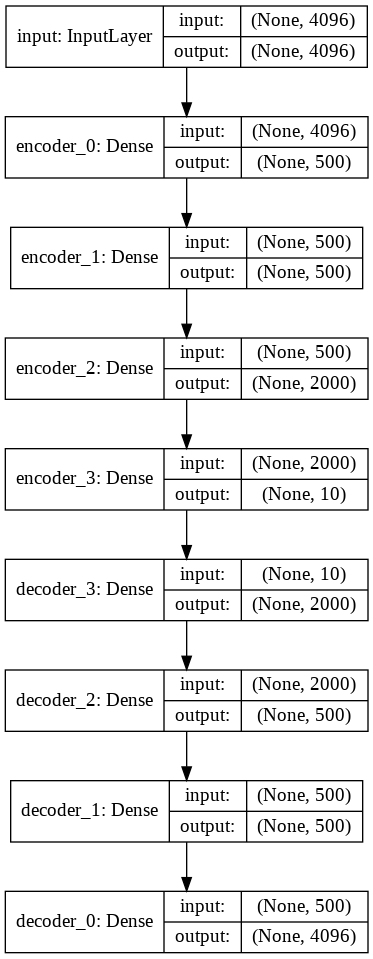

In [12]:
from keras.utils import plot_model
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)
from IPython.display import Image
Image(filename='autoencoder.png')

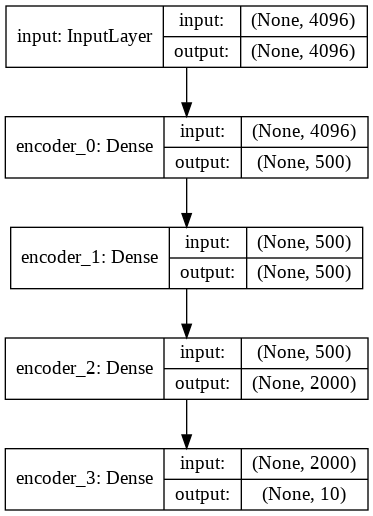

In [13]:
from keras.utils import plot_model
plot_model(encoder, to_file='encoder.png', show_shapes=True)
from IPython.display import Image
Image(filename='encoder.png')

In [20]:
autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
autoencoder.fit(x, x, batch_size=batch_size, epochs=pretrain_epochs)
autoencoder.save_weights('/content/drive/My Drive/ae_weights_set2.h5')

Epoch 1/300
2197/2197 [==============================] - 3s 1ms/step - loss: 0.0024
Epoch 2/300
2197/2197 [==============================] - 3s 1ms/step - loss: 0.0024
Epoch 3/300
2197/2197 [==============================] - 3s 1ms/step - loss: 0.0023
Epoch 4/300
2197/2197 [==============================] - 3s 1ms/step - loss: 0.0023
Epoch 5/300
2197/2197 [==============================] - 3s 1ms/step - loss: 0.0023
Epoch 6/300
2197/2197 [==============================] - 3s 1ms/step - loss: 0.0022
Epoch 7/300
2197/2197 [==============================] - 3s 1ms/step - loss: 0.0022
Epoch 8/300
2197/2197 [==============================] - 3s 1ms/step - loss: 0.0022
Epoch 9/300
2197/2197 [==============================] - 3s 1ms/step - loss: 0.0022
Epoch 10/300
2197/2197 [==============================] - 3s 1ms/step - loss: 0.0022
Epoch 11/300
2197/2197 [==============================] - 3s 1ms/step - loss: 0.0022
Epoch 12/300
2197/2197 [==============================] - 3s 1ms/step - lo

In [21]:
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)

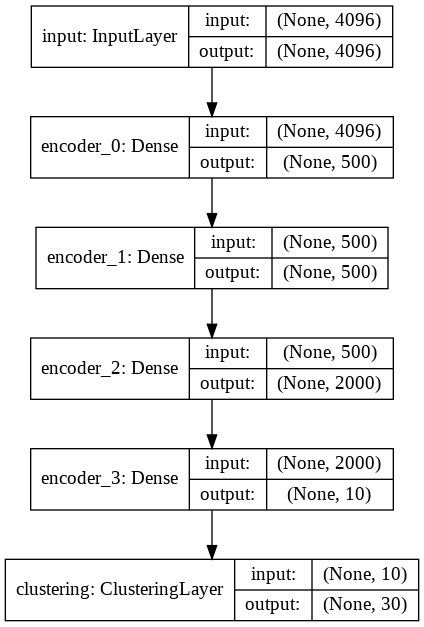

In [22]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png')

In [23]:
model.compile(optimizer=SGD(0.01, 0.9), loss='kld')

In [24]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred_kmeans = kmeans.fit_predict(encoder.predict(x))

In [25]:
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

In [26]:
# deep clustering

# computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

    
loss = 0
index = 0
maxiter = 1000 # 8000
update_interval = 100 # 140
index_array = np.arange(x.shape[0])

In [27]:
tol = 0.001 # tolerance threshold to stop training

In [28]:
#Train DEC model iteratively

for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights('/content/drive/My Drive/DEC_model_final_set2_300.h5')
#Load the clustering model trained weights
model.load_weights('/content/drive/My Drive/DEC_model_final_set2_300.h5')

In [29]:
# Eval.
q = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)

In [30]:
y_pred_last = y_pred

In [31]:
#Append Cluster Labels to our preprocessced data frame:

data_all = df.copy()

In [32]:
data_all['cluster'] = y_pred
data_all.head()

,Unnamed: 0,_id,topic,content,processed_content,processed_topic,cluster
0,0,5f04e496ef217aae6a201f71,"[""National""]","[""The West Bengal government on Tuesday decide...",west bengal govern tuesday decid impos complet...,nation,21
1,1,5f04e498ef217aae6a201f72,"[""Business""]","[""The government is weighing the pros and cons...",govern weigh pros con halt import includ china...,busi,22
2,2,5f04e49aef217aae6a201f73,"[""National""]","[""The Central Board of Secondary Education (CB...",central board secondari educ cbse slash syllab...,nation,25
3,3,5f04e49def217aae6a201f74,"[""International""]","[""The World Health Organization on Tuesday ack...",world health organ tuesday acknowledg emerg ev...,intern,27
4,4,5f04e49fef217aae6a201f75,"[""International""]","[""President Donald Trump on Tuesday formally s...",presid donald trump tuesday formal start withd...,intern,7


In [33]:
data_all.to_csv('/content/drive/My Drive/clustered_all_news_set2_300.csv')

In [34]:
data_all['cluster'].value_counts()

5     161
26    155
14    147
9     112
15     99
7      98
20     93
4      84
21     82
6      73
27     73
19     68
23     68
28     68
22     66
8      65
12     65
17     64
13     63
18     61
29     60
25     60
0      60
24     59
11     51
10     50
2      40
16     38
1       7
3       7
Name: cluster, dtype: int64

In [35]:
#Dimension reduction and visualisation of clustering labels

import numpy as np
from sklearn.manifold import TSNE

x_embedded = TSNE(n_components=2).fit_transform(x)

x_embedded.shape

(2197, 2)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


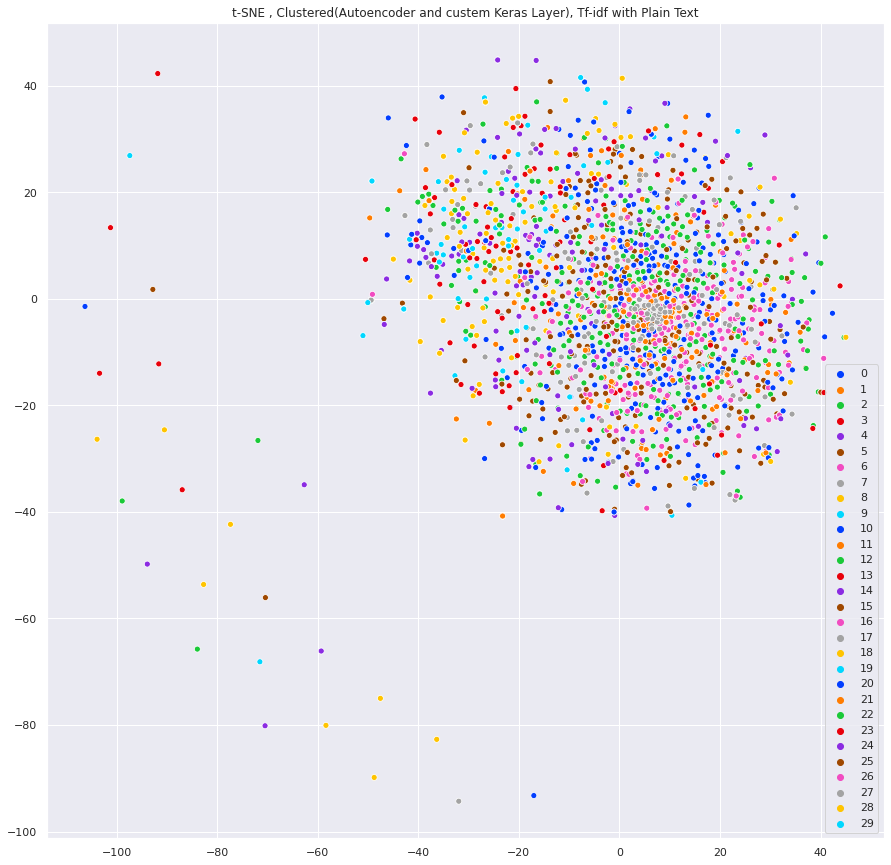

In [36]:
#Plot the Cluster as scatter plot

from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", len(set(y_pred)))

# plot
sns.scatterplot(x_embedded[:,0], x_embedded[:,1], hue=y_pred_kmeans, legend='full', palette=palette)
plt.title("t-SNE , Clustered(Autoencoder and custem Keras Layer), Tf-idf with Plain Text")
# plt.savefig("plots/t-sne_covid19_label_TFID.png")
plt.show()

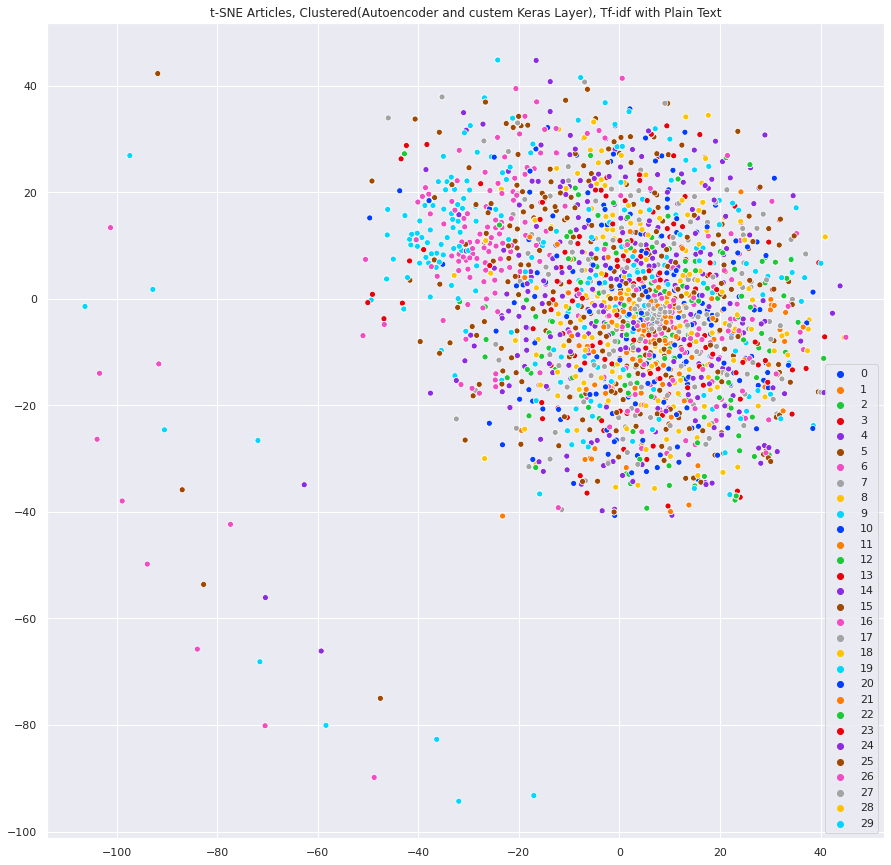

In [37]:
#Plot the Cluster as scatter plot

from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", len(set(y_pred)))

# plot
sns.scatterplot(x_embedded[:,0], x_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title("t-SNE Articles, Clustered(Autoencoder and custem Keras Layer), Tf-idf with Plain Text")
# plt.savefig("plots/t-sne_covid19_label_TFID.png")
plt.show()

In [39]:
y_pred

array([21, 22, 25, ..., 13,  6, 19])

In [33]:
y_pred_kmeans.shape

(2197,)

In [38]:
# for AE
from sklearn.metrics import normalized_mutual_info_score
ae_nmi_cos = normalized_mutual_info_score(df.topic,y_pred)
ae_nmi_cos = ae_nmi_cos*100

In [40]:
ae_nmi_cos

17.413182441240455

In [41]:
# for k-means
from sklearn.metrics import normalized_mutual_info_score
ae_nmi_cos = normalized_mutual_info_score(df.topic,y_pred_kmeans)
ae_nmi_cos = ae_nmi_cos*100

In [42]:
ae_nmi_cos

16.175537075126886

In [43]:
#vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, maxx_features):
    
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

text = df['processed_content'].values
X1 = vectorize(text, 2 ** 12)
X1.shape

(2197, 4096)

In [44]:
# function to print out classification model report
def classification_report(model_name, test, pred):
    from sklearn.metrics import precision_score, recall_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import f1_score
    
    print(model_name, ":\n")
    print("Accuracy Score: ", '{:,.3f}'.format(float(accuracy_score(test, pred)) * 100), "%")
    print("     Precision: ", '{:,.3f}'.format(float(precision_score(test, pred, average='macro')) * 100), "%")
    print("        Recall: ", '{:,.3f}'.format(float(recall_score(test, pred, average='macro')) * 100), "%")
    print("      F1 score: ", '{:,.3f}'.format(float(f1_score(test, pred, average='macro')) * 100), "%")
    
#Let's split the data into train/test sets

from sklearn.model_selection import train_test_split

# test set size of 20% of the data and the random seed 42 <3
X_train, X_test, y_train, y_test = train_test_split(X1.toarray(),y_pred, test_size=0.2, random_state=42)

print("X_train size:", len(X_train))
print("X_test size:", len(X_test), "\n")

X_train size: 1757
X_test size: 440 



In [45]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier

# SGD instance
sgd_clf = SGDClassifier(max_iter=10000, tol=1e-3, random_state=42, n_jobs=4)
# train SGD
sgd_clf.fit(X_train, y_train)

# cross validation predictions
sgd_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3, n_jobs=4)

# print out the classification report
classification_report("Stochastic Gradient Descent Report (Training Set)", y_train, sgd_pred)

Stochastic Gradient Descent Report (Training Set) :

Accuracy Score:  21.172 %
     Precision:  22.521 %
        Recall:  19.955 %
      F1 score:  20.359 %


In [46]:
# cross validation predictions
sgd_pred = cross_val_predict(sgd_clf, X_test, y_test, cv=3, n_jobs=4)

# print out the classification report
classification_report("Stochastic Gradient Descent Report (Training Set)", y_test, sgd_pred)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Stochastic Gradient Descent Report (Training Set) :

Accuracy Score:  11.364 %
     Precision:  17.487 %
        Recall:  8.695 %
      F1 score:  9.911 %


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
sgd_cv_score = cross_val_score(sgd_clf, X.toarray(), y_pred, cv=10)
print("Mean cv Score - SGD: {:,.3f}".format(float(sgd_cv_score.mean()) * 100), "%")

In [47]:
from sklearn.metrics import silhouette_score

# centers = kmeans.cluster_centers_
score = silhouette_score (x, y_pred_kmeans, metric='euclidean')
print ("For n_clusters = {}, Kmeans silhouette score is {})".format(n_clusters, score))

For n_clusters = 30, Kmeans silhouette score is -0.19105496565877564)


In [48]:
score = silhouette_score (x, y_pred, metric='euclidean')
print ("For n_clusters = {}, Deep clustering silhouette score is {})".format(n_clusters, score))

For n_clusters = 30, Deep clustering silhouette score is -0.19092646019866033)


In [48]:
for num_clusters in range(2,5):
    clusterer = KMeans(n_clusters=num_clusters, n_jobs=4)
    preds = clusterer.fit_predict(x)
    # centers = clusterer.cluster_centers_
    score = silhouette_score (x, preds, metric='euclidean')
    print ("For n_clusters = {}, Kmeans silhouette score is {})".format(num_clusters, score))

For n_clusters = 2, Kmeans silhouette score is 0.8860526986768783)
For n_clusters = 3, Kmeans silhouette score is 0.2775788629125588)
For n_clusters = 4, Kmeans silhouette score is 0.2738633116748086)


In [ ]:
# Fully connected layer

In [84]:
# # Need to re-run autoencoder function declaration!!!
# def autoencoder(dims, act='relu', init='glorot_uniform'):
#     """
#     Fully connected auto-encoder model, symmetric.
#     Arguments:
#         dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
#             The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
#         act: activation, not applied to Input, Hidden and Output layers
#     return:
#         (ae_model, encoder_model), Model of autoencoder and model of encoder
#     """
#     n_stacks = len(dims) - 1
#     # input
#     input_data = Input(shape=(dims[0],), name='input')
#     x = input_data
    
#     # internal layers in encoder
#     for i in range(n_stacks-1):
#         x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

#     # hidden layer
#     encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

#     x = encoded
#     # internal layers in decoder
#     for i in range(n_stacks-1, 0, -1):
#         x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

#     # output
#     x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
#     decoded = x


#     autoencoder_model = Model(inputs=input_data, outputs=decoded, name='autoencoder')
#     encoder_model     = Model(inputs=input_data, outputs=encoded, name='encoder')


#     return Model(inputs=input_data, outputs=decoded, name='AE'), Model(inputs=input_data, outputs=encoded, name='encoder')

In [85]:
# autoencoder, encoder = autoencoder(dims, init=init)
# autoencoder.load_weights('/content/drive/My Drive/ae_weights.h5')
# clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
# model = Model(inputs=encoder.input, outputs=[clustering_layer, autoencoder.output])

In [86]:
# from keras.utils import plot_model
# plot_model(model, to_file='model.png', show_shapes=True)
# from IPython.display import Image
# Image(filename='model.png')

In [89]:
# kmeans = KMeans(n_clusters=n_clusters, n_init=20)
# y_pred = kmeans.fit_predict(encoder.predict(x))
# model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
# y_pred_last = np.copy(y_pred)

In [88]:
# model.compile(loss=['kld', 'mse'], loss_weights=[0.1, 1], optimizer=pretrain_optimizer)

In [87]:
# for ite in range(int(maxiter)):
#     if ite % update_interval == 0:
#         q, _  = model.predict(x, verbose=0)
#         p = target_distribution(q)  # update the auxiliary target distribution p

#         # evaluate the clustering performance
#         y_pred = q.argmax(1)

#         # check stop criterion
#         delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
#         y_pred_last = np.copy(y_pred)
#         if ite > 0 and delta_label < tol:
#             print('delta_label ', delta_label, '< tol ', tol)
#             print('Reached tolerance threshold. Stopping training.')
#             break
#     idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
#     loss = model.train_on_batch(x=x[idx], y=[p[idx], x[idx]])
#     index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

# model.save_weights('/content/drive/My Drive/b_DEC_model_finalll.h5')

In [ ]:
model.load_weights('/content/drive/My Drive/b_DEC_model_finalll.h5')

In [83]:
# # evaluation of model prediction 
# q, _ = model.predict(x, verbose=0)
# p = target_distribution(q)  # update the auxiliary target distribution p

# # evaluate the clustering performance
# y_pred = q.argmax(1)

In [82]:
# score = silhouette_score (x, y_pred, metric='euclidean')
# print ("For n_clusters = {}, Deep clustering silhouette score is {})".format(n_clusters, score))

In [81]:
# # plt.scatter(vis_x, vis_y, c=y_pred, cmap=plt.cm.get_cmap("jet", n_clusters))
# # plt.colorbar(ticks=range(n_clusters))
# plt.scatter(x_embedded[:,0], x_embedded[:,1], c=y_pred, cmap=plt.cm.get_cmap("jet", 256))
# plt.colorbar(ticks=range(256))
# plt.clim(-0.5, 9.5)
# plt.show()

In [80]:
# plt.scatter(x_embedded[:,0], x_embedded[:,1], c=y_pred_kmeans, cmap=plt.cm.get_cmap("jet", 256))
# plt.colorbar(ticks=range(256))
# plt.clim(-0.5, 9.5)
# plt.show()


In [79]:
# data_all['cluster'] = y_pred

# data_all['cluster'].value_counts()

In [78]:
# data_cluster_1 = data_all[data_all['cluster'] == 1]
# data_cluster_1.describe()

In [77]:
# data_cluster_2 = data_all[data_all['cluster'] == 2]
# data_cluster_2.describe()

In [76]:
# import numpy as np
# from sklearn.decomposition import PCA

# pca = PCA(n_components=2)
# x_pca = pca.fit_transform(x)

# x_pca.shape


In [75]:

# vis_x = x_pca[:, 0]
# vis_y = x_pca[:, 1]
# plt.scatter(x_embedded[:,0], x_embedded[:,1], c=y_pred, cmap=plt.cm.get_cmap("jet", 256))
# plt.colorbar(ticks=range(256))
# plt.clim(-0.5, 9.5)
# plt.show()

In [74]:
# data_full_ae = data_all.copy()

# data_full_ae['full_ae_cluster'] = y_pred
# data_full_ae.head(50)

Topic Modelling

In [14]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [49]:
#First we will create 20 vectorizers, one for each of our cluster labels

vectorizers = []
    
for ii in range(0, 30):
    # Creating a vectorizer
    vectorizers.append(CountVectorizer(stop_words='english'))

In [50]:
vectorizers[0]

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [51]:
#Now we will vectorize the data from each of our clusters

vectorized_data = []

for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(data_all.loc[data_all.cluster == current_cluster, 'processed_content']))
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)
len(vectorized_data)

30

In [52]:
 #number of topics per cluster
NUM_TOPICS_PER_CLUSTER = 20

lda_models = []
for ii in range(0, 30):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, learning_method='online',verbose=False, random_state=42)
    lda_models.append(lda)
    
lda_models[0]

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=20, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=False)

In [53]:
#For each cluster, we had created a correspoding LDA model in the previous step. We will now fit_transform all the LDA models on their respective cluster vectors

clusters_lda_data = []

for current_cluster, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_cluster))
    
    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))

In [54]:
#Extracts the keywords from each cluster

# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values


In [55]:
#Append list of keywords for a single cluster to 2D list of length NUM_TOPICS_PER_CLUSTER

all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))
all_keywords[3][:10]

['harri',
 'gift',
 'saroj',
 'india',
 'know',
 'petit',
 'year',
 'fight',
 'jeanmair',
 'nplay']

In [60]:
len(all_keywords)

30

NMF

In [61]:
from sklearn.decomposition import NMF


In [63]:
 #number of topics per cluster
NUM_TOPICS_PER_CLUSTER = 20

nmf_models = []
for ii in range(0, 30):
    # Latent Dirichlet Allocation Model
    nmf = NMF(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10,verbose=False, random_state=42)
    nmf_models.append(nmf)
    
nmf_models[0]

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=10,
    n_components=20, random_state=42, shuffle=False, solver='cd', tol=0.0001,
    verbose=False)

In [64]:
#For each cluster, we had created a correspoding LDA model in the previous step. We will now fit_transform all the LDA models on their respective cluster vectors

clusters_nmf_data = []

for current_cluster, nmf in enumerate(nmf_models):
    # print("Current Cluster: " + str(current_cluster))
    
    if vectorized_data[current_cluster] != None:
        clusters_nmf_data.append((nmf.fit_transform(vectorized_data[current_cluster])))

In [65]:
#Extracts the keywords from each cluster

# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values


In [66]:
#Append list of keywords for a single cluster to 2D list of length NUM_TOPICS_PER_CLUSTER

all_keywords = []
for current_vectorizer, nmf in enumerate(nmf_models):
    # print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(nmf, vectorizers[current_vectorizer]))
all_keywords[3][:10]

['harri',
 'singh',
 'gift',
 'know',
 'fight',
 'base',
 'hospit',
 'weasley',
 'india',
 'nplay']

In [59]:
#lda

for i in range(0,30):
  print(all_keywords[i][:10])

['test', 'say', 'price', 'pakistan', 'covid', 'case', 'student', 'gold', 'state', 'gandhi']
['video', 'indian', 'altern', 'user', 'contain', 'million', 'develop', 'jiayun', 'expert', 'multiplatform']
['district', 'state', 'govern', 'hospit', 'posit', 'india', 'armi', 'bhatkal', 'peopl', 'disengag']
['harri', 'gift', 'saroj', 'india', 'know', 'petit', 'year', 'fight', 'jeanmair', 'nplay']
['test', 'state', 'student', 'say', 'polic', 'govern', 'countri', 'patient', 'covid', 'hospit']
['china', 'polic', 'media', 'film', 'dubey', 'chines', 'covid', 'time', 'home', 'say']
['case', 'state', 'death', 'govern', 'ziva', 'bird', 'result', 'offic', 'hospit', 'exam']
['india', 'china', 'technolog', 'recognit', 'infect', 'say', 'parti', 'wildlif', 'univers', 'vaccin']
['parti', 'coronavirus', 'esha', 'children', 'polic', 'covid', 'elect', 'price', 'case', 'sushant']
['film', 'year', 'meat', 'chines', 'coffe', 'choic', 'write', 'chris', 'eat', 'vaccin']
['hospit', 'covid', 'chines', 'troop', 'result

In [67]:
#nmf

for i in range(0,30):
  print(all_keywords[i][:10])

['test', 'say', 'percent', 'price', 'case', 'continu', 'busi', 'kong', 'hong', 'polic']
['user', 'indian', 'altern', 'award', 'saver', 'video', 'million', 'sell', 'lock', 'inshot']
['district', 'health', 'posit', 'hospit', 'mental', 'garmin', 'uttara', 'raid', 'india', 'gold']
['harri', 'singh', 'gift', 'know', 'fight', 'base', 'hospit', 'weasley', 'india', 'nplay']
['say', 'govern', 'india', 'data', 'patient', 'student', 'case', 'cent', 'work', 'crore']
['say', 'chini', 'dubey', 'china', 'india', 'polic', 'taiwan', 'media', 'drug', 'onion']
['minist', 'exam', 'case', 'result', 'lockdown', 'covid', 'board', 'price', 'state', 'report']
['say', 'india', 'infect', 'huawei', 'univers', 'parti', 'china', 'technolog', 'coal', 'plasma']
['esha', 'school', 'children', 'price', 'say', 'elect', 'court', 'presid', 'forc', 'spend']
['film', 'statu', 'cafe', 'china', 'fish', 'meat', 'pakistan', 'food', 'mar', 'scienc']
['say', 'hospit', 'virus', 'result', 'test', 'case', 'covid', 'chines', 'troop',